In [3]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
import matplotlib.transforms
from scipy.interpolate import RegularGridInterpolator

from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs

glasflow is using its own internal version of nflows


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [14]:
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'

#CE channel
samples_dict = read_models.read_hdf5(file_path, 'CE')
sensitivity ='midhighlatelow_network'
alpha = np.zeros((4,5))
mass = np.zeros((4,5))
mass_power = np.zeros((4,5))
chi_b=['0.','0.1','0.2','0.5']

for chib_id in range(4):
    for alphaCE_id in range(5):
        samples = samples_dict[(chib_id,alphaCE_id)]
        mock_samp = samples.sample(int(1e6), weights=(samples['weight']/len(samples)), replace=True)
        alpha[chib_id,alphaCE_id] = np.sum(mock_samp['pdet_'+sensitivity]) / len(mock_samp)
        mass_power[chib_id,alphaCE_id] = np.mean(samples['mchirp']**(5/6))
        mass[chib_id,alphaCE_id] = np.mean(samples['mchirp'])

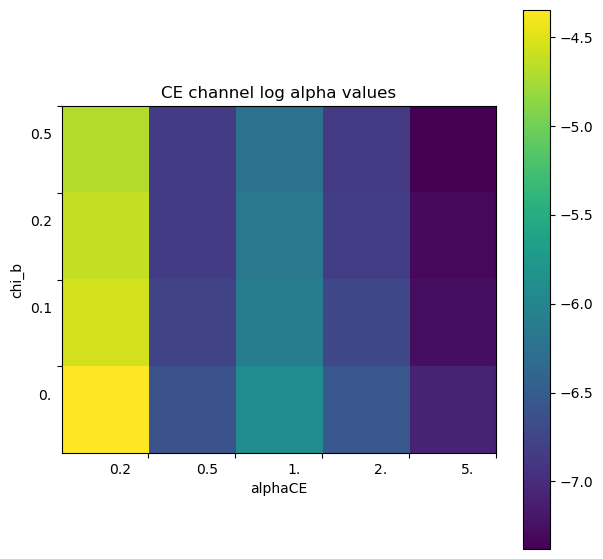

In [15]:
#plot CE channel
fig,ax=plt.subplots(1,1)

plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(np.log(alpha), extent=(0,5,0,4))
plt.colorbar()
plt.title('CE channel log alpha values')
plt.xlabel('alphaCE')
plt.ylabel('chi_b')

ax.set_yticks([1,2,3,4])
ax.set_yticklabels(chi_b)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['0.2','0.5','1.','2.', '5.'])
dx = 0/72.; dy = -20/72. 
offsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsety)
dxx = -20/72.; dyx = 0/72.
offsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)
for label in ax.xaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsetx)

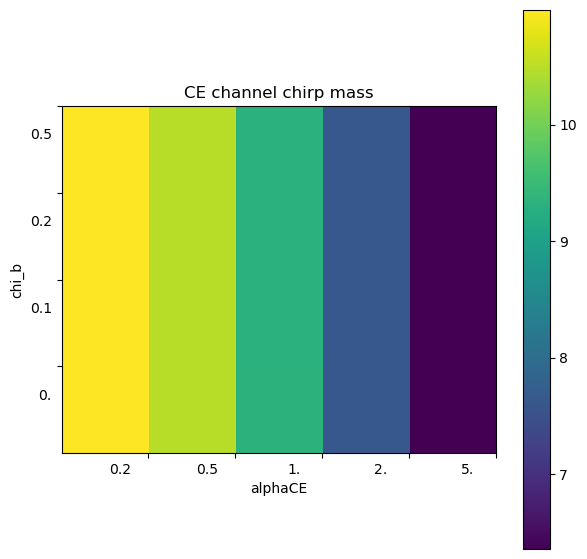

In [13]:
#plot CE channel mass
fig,ax=plt.subplots(1,1)

plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(mass, extent=(0,5,0,4))
plt.colorbar()
plt.title('CE channel chirp mass')
plt.xlabel('alphaCE')
plt.ylabel('chi_b')

ax.set_yticks([1,2,3,4])
ax.set_yticklabels(chi_b)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['0.2','0.5','1.','2.', '5.'])
dx = 0/72.; dy = -20/72. 
offsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsety)
dxx = -20/72.; dyx = 0/72.
offsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)
for label in ax.xaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsetx)

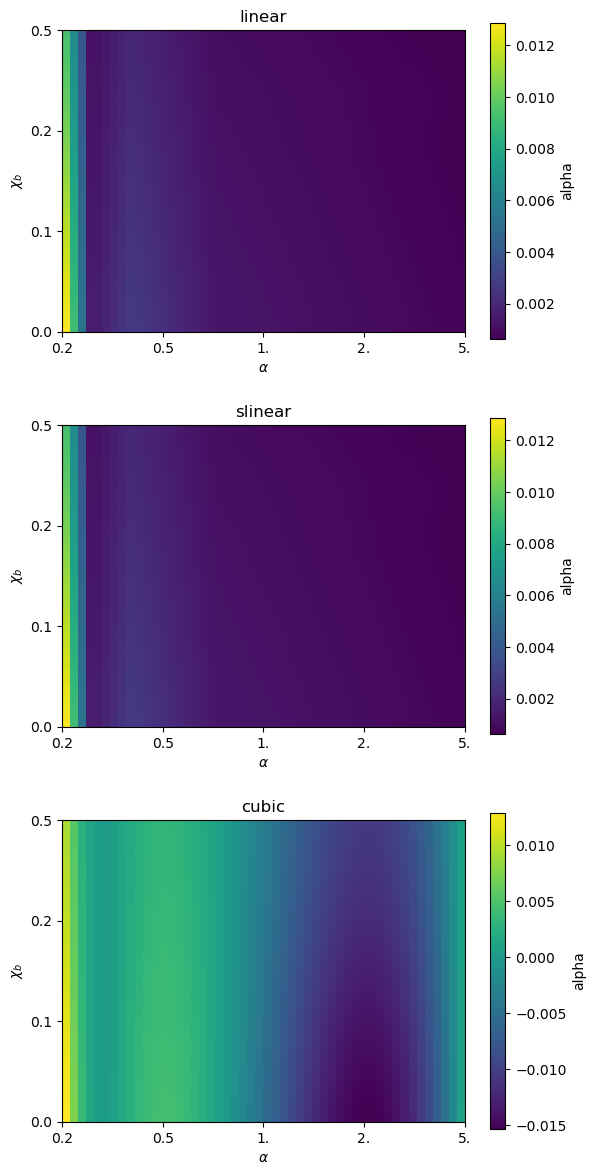

In [6]:
#interpolating alpha values

plt.rcParams["figure.figsize"] = (6,12)
fig2, ax2 = plt.subplots(3,1)

grid_new_res = 50
chi_b=[0.,0.1,0.2,0.5]
alphaCE=[0.2,0.5,1.,2.,5.]
grid_new = np.meshgrid(np.linspace(chi_b[0],chi_b[-1], grid_new_res),np.linspace(alphaCE[0],alphaCE[-1],grid_new_res))
grid = np.meshgrid(chi_b,alphaCE)
#grid = np.meshgrid([0,1,2,3,4],[0,1,2,3])

for i, interp_method in enumerate(['linear','slinear','cubic']):

    f = RegularGridInterpolator((chi_b,alphaCE), alpha, bounds_error=False, fill_value=None, method=interp_method)
    
    contour=ax2[i].imshow(np.swapaxes(f((grid_new[0],grid_new[1])),0,1), extent=(0,4,0,3))
    #ax2[i].plot(grid[0],grid[1], 'o', color='black')
    ax2[i].set_ylabel(fr'$\chi_b$')
    ax2[i].set_xlabel(r'$\alpha$')
    ax2[i].set_yticks([0,1,2,3])
    ax2[i].set_yticklabels(chi_b)
    ax2[i].set_xticks([0,1,2,3,4])
    ax2[i].set_xticklabels(['0.2','0.5','1.','2.', '5.'])
    ax2[i].set_title(interp_method)
    fig2.colorbar(contour, ax=ax2[i], label=r'alpha')

plt.tight_layout()
plt.show()

In [9]:
#not CE channels
alpha_notCE = np.zeros((4,4))
mass_notCE = np.zeros((4,4))
channels = ['CHE','GC','NSC','SMT']

channel_no = 0
for channel in channels:
    samples_dict = read_models.read_hdf5(file_path, channel)
    for chib_id in range(4):
            samples = samples_dict[(chib_id)]
            mock_samp = samples.sample(int(1e6), weights=(samples['weight']/len(samples)), replace=True)
            alpha_notCE[channel_no,chib_id] = np.sum(mock_samp['pdet_'+sensitivity]) / len(mock_samp)
            mass_notCE[channel_no,chib_id] = np.sum(mock_samp['mchirp']**(5/6)) / len(mock_samp)
    channel_no+=1


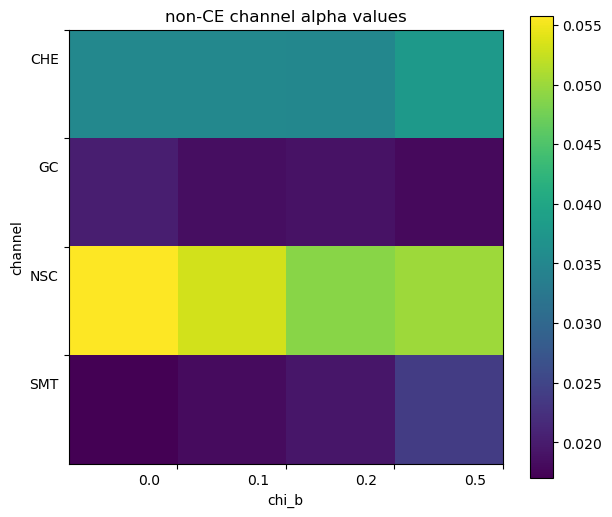

In [10]:
#plot not CE channels

plt.rcParams["figure.figsize"] = (7,6)
fig,ax=plt.subplots(1,1)
plt.imshow(alpha_notCE, extent=(0,4,0,4))
plt.colorbar()
plt.title('non-CE channel alpha values')
plt.xlabel('chi_b')
plt.ylabel('channel')

ax.set_yticks([1,2,3,4])
ax.set_yticklabels(np.flip(channels))
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(chi_b)
dx = 0/72.; dy = -20/72. 
offsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsety)
dxx = -20/72.; dyx = 0/72.
offsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)
for label in ax.xaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsetx)

[0.03502708 0.02023773 0.05545917 0.01717963]
[0.03501649 0.01867169 0.05318617 0.0181773 ]
[0.0350345  0.01896213 0.04900084 0.01946683]
[0.03811338 0.01808658 0.05036066 0.02380794]


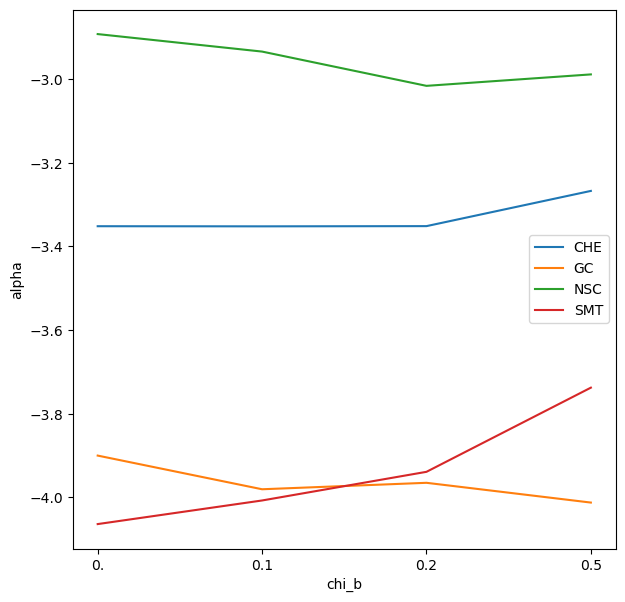

In [11]:
channel_no=0
for channel in channels:
    plt.plot(chi_b, np.log(alpha_notCE[channel_no,:]), label=channels[channel_no])
    print(alpha_notCE[:,channel_no])
    #plt.yscale('log')
    plt.xlabel('chi_b')
    plt.ylabel('alpha')
    plt.legend()
    channel_no+=1

[0.03519931 0.02031159 0.05591169 0.01728929]
[0.03517004 0.01865494 0.05310779 0.01809835]
[0.03517188 0.01895927 0.0487957  0.01945902]
[0.03783275 0.0180554  0.05035794 0.02376488]


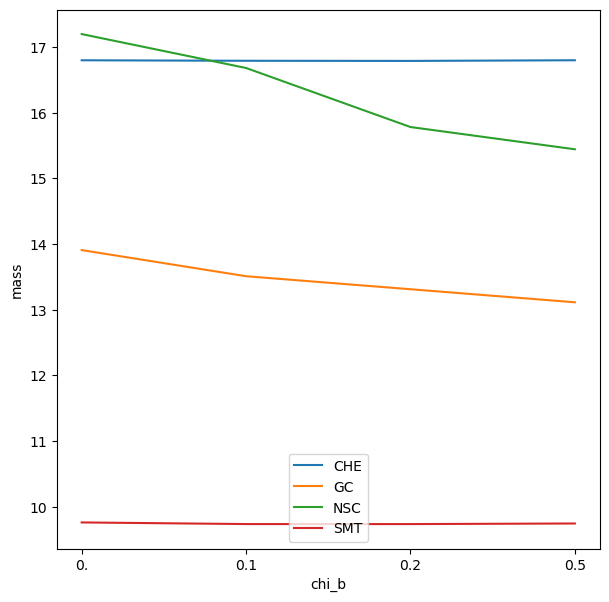

In [7]:
channel_no=0
for channel in channels:
    plt.plot(chi_b, mass_notCE[channel_no,:], label=channels[channel_no])
    print(alpha_notCE[:,channel_no])
    #plt.yscale('log')
    plt.xlabel('chi_b')
    plt.ylabel('mass')
    plt.legend()
    channel_no+=1